In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
import time

sys.path.append('src')

import config
from models import get_model
from datasets.brain_tumor_dataset import get_dataloaders
from losses.combined_loss import MultiTaskLoss
from utils.metrics import (
    calculate_classification_metrics, 
    calculate_iou,
    calculate_dice_coefficient,
    count_parameters
)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Imports successful")
print(f"Device: {config.DEVICE}")

/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Imports successful
Device: cuda


## 2. Configuration

In [2]:
# Models and their checkpoints
MODELS_TO_TEST = {
    # 'swin': 'checkpoints/swin_best.pth',
    'vit': 'checkpoints/vit_best.pth',
    'unet': 'checkpoints/unet_best.pth',
    'resnet_unet': 'checkpoints/resnet_unet_best.pth',
    'segformer': 'checkpoints/segformer_best.pth',
    # 'fast_scnn': 'checkpoints/fast_scnn_best.pth',
    # 'bisenetv2': 'checkpoints/bisenetv2_best.pth',
    'segnext': 'checkpoints/segnext_best.pth',
    'efficient_mtnet': 'checkpoints/efficient_mtnet_best.pth'
}

# Visualization settings
NUM_SAMPLES_TO_DISPLAY = 5
SAVE_ALL_TEST_IMAGES = True

print(f"Models to test: {list(MODELS_TO_TEST.keys())}")
print(f"Samples to display in notebook: {NUM_SAMPLES_TO_DISPLAY}")
print(f"Save all test images: {SAVE_ALL_TEST_IMAGES}")

Models to test: ['vit', 'unet', 'resnet_unet', 'segformer', 'segnext', 'efficient_mtnet']
Samples to display in notebook: 5
Save all test images: True


## 3. Load Test Data

In [3]:
print("Loading test dataset...")
_, _, test_loader = get_dataloaders(
    train_dir=config.TRAIN_DIR,
    val_dir=config.VAL_DIR,
    test_dir=config.TEST_DIR,
    train_ann=config.TRAIN_ANNOTATIONS,
    val_ann=config.VAL_ANNOTATIONS,
    test_ann=config.TEST_ANNOTATIONS,
    batch_size=8,
    num_workers=4,
    image_size=config.IMAGE_SIZE
)

print(f"✓ Test data loaded: {len(test_loader)} batches")

Loading test dataset...
✓ Test data loaded: 27 batches


## 4. Test All Models

In [4]:
def test_model(model_name, checkpoint_path):
    """
    Test a single model and return comprehensive metrics
    """
    print(f"\n{'='*60}")
    print(f"Testing: {model_name.upper()}")
    print(f"{'='*60}")
    
    # Load model
    model = get_model(
        model_name=model_name,
        n_classes_seg=config.SEGMENTATION_CLASSES,
        n_classes_cls=config.NUM_CLASSES - 1,
        img_size=config.IMAGE_SIZE
    ).to(config.DEVICE)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    num_params = count_parameters(model)
    print(f"Parameters: {num_params:,} ({num_params/1e6:.2f}M)")
    
    # Initialize criterion
    criterion = MultiTaskLoss(
        classification_weight=config.CLASSIFICATION_WEIGHT,
        segmentation_weight=config.SEGMENTATION_WEIGHT
    )
    
    # Test loop
    test_loss = 0.0
    all_cls_preds, all_cls_targets = [], []
    all_seg_preds, all_seg_targets = [], []
    inference_times = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Testing'):
            images = batch['image'].to(config.DEVICE)
            seg_masks = batch['segmentation_mask'].to(config.DEVICE)
            cls_labels = batch['classification_label'].to(config.DEVICE)
            
            # Measure inference time
            start_time = time.time()
            cls_output, seg_output = model(images)
            inference_time = time.time() - start_time
            inference_times.append(inference_time / images.size(0))
            
            # Calculate loss
            loss_dict = criterion(cls_output, seg_output, cls_labels, seg_masks)
            test_loss += loss_dict['total_loss'].item()
            
            # Store predictions
            all_cls_preds.append(torch.argmax(cls_output, dim=1).cpu())
            all_cls_targets.append(cls_labels.cpu())
            all_seg_preds.append(torch.argmax(seg_output, dim=1).cpu())
            all_seg_targets.append(seg_masks.cpu())
    
    # Concatenate predictions
    all_cls_preds = torch.cat(all_cls_preds)
    all_cls_targets = torch.cat(all_cls_targets)
    all_seg_preds = torch.cat(all_seg_preds)
    all_seg_targets = torch.cat(all_seg_targets)
    
    # Calculate metrics
    test_loss /= len(test_loader)
    cls_metrics = calculate_classification_metrics(all_cls_preds, all_cls_targets)
    seg_iou = calculate_iou(all_seg_preds, all_seg_targets, num_classes=2)
    seg_dice = calculate_dice_coefficient(all_seg_preds, all_seg_targets, num_classes=2)
    
    avg_inference_time = np.mean(inference_times)
    fps = 1.0 / avg_inference_time
    
    # Confusion matrix
    cm = confusion_matrix(all_cls_targets.numpy(), all_cls_preds.numpy())
    
    # Results dictionary
    results = {
        'model_name': model_name,
        'parameters': num_params,
        'test_loss': test_loss,
        'accuracy': cls_metrics['accuracy'],
        'precision': cls_metrics['precision'],
        'recall': cls_metrics['recall'],
        'f1_score': cls_metrics['f1_score'],
        'mean_iou': seg_iou,
        'dice_coefficient': seg_dice,
        'inference_time': avg_inference_time,
        'fps': fps,
        'confusion_matrix': cm,
        'predictions': {
            'cls_preds': all_cls_preds,
            'cls_targets': all_cls_targets,
            'seg_preds': all_seg_preds,
            'seg_targets': all_seg_targets
        }
    }
    
    # Print summary
    print(f"\nTest Results:")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  Classification Accuracy: {cls_metrics['accuracy']:.4f}")
    print(f"  Precision: {cls_metrics['precision']:.4f}")
    print(f"  Recall: {cls_metrics['recall']:.4f}")
    print(f"  F1-Score: {cls_metrics['f1_score']:.4f}")
    print(f"  Segmentation mIoU: {seg_iou:.4f}")
    print(f"  Dice Coefficient: {seg_dice:.4f}")
    print(f"  Inference Time: {avg_inference_time*1000:.2f} ms/image")
    print(f"  FPS: {fps:.2f}")
    
    return results

# Test all models
all_results = {}

for model_name, checkpoint_path in MODELS_TO_TEST.items():
    if os.path.exists(checkpoint_path):
        results = test_model(model_name, checkpoint_path)
        all_results[model_name] = results
    else:
        print(f"\n⚠ Checkpoint not found: {checkpoint_path}")

print(f"\n✓ Testing completed for {len(all_results)} models")


Testing: VIT
Parameters: 89,537,220 (89.54M)


Testing: 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]



Test Results:
  Test Loss: 0.0892
  Classification Accuracy: 0.9767
  Precision: 0.9777
  Recall: 0.9767
  F1-Score: 0.9767
  Segmentation mIoU: 0.7554
  Dice Coefficient: 0.8424
  Inference Time: 2.31 ms/image
  FPS: 433.64

Testing: UNET
Parameters: 31,569,412 (31.57M)


Testing: 100%|██████████| 27/27 [00:04<00:00,  5.98it/s]



Test Results:
  Test Loss: 0.0864
  Classification Accuracy: 0.9860
  Precision: 0.9861
  Recall: 0.9860
  F1-Score: 0.9860
  Segmentation mIoU: 0.7160
  Dice Coefficient: 0.8078
  Inference Time: 1.14 ms/image
  FPS: 878.69

Testing: RESNET_UNET


/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/siu856569517/.conda/envs/brain_tumor/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameters: 60,565,156 (60.57M)


Testing: 100%|██████████| 27/27 [00:03<00:00,  7.62it/s]



Test Results:
  Test Loss: 0.0550
  Classification Accuracy: 0.9953
  Precision: 0.9954
  Recall: 0.9953
  F1-Score: 0.9954
  Segmentation mIoU: 0.8017
  Dice Coefficient: 0.8788
  Inference Time: 0.96 ms/image
  FPS: 1037.31

Testing: SEGFORMER
Parameters: 4,083,876 (4.08M)


Testing: 100%|██████████| 27/27 [00:02<00:00, 11.84it/s]



Test Results:
  Test Loss: 0.1205
  Classification Accuracy: 0.9628
  Precision: 0.9628
  Recall: 0.9628
  F1-Score: 0.9628
  Segmentation mIoU: 0.7205
  Dice Coefficient: 0.8122
  Inference Time: 0.97 ms/image
  FPS: 1029.29

Testing: SEGNEXT
Parameters: 2,586,468 (2.59M)


Testing: 100%|██████████| 27/27 [00:02<00:00, 11.67it/s]



Test Results:
  Test Loss: 0.1049
  Classification Accuracy: 0.9674
  Precision: 0.9675
  Recall: 0.9674
  F1-Score: 0.9675
  Segmentation mIoU: 0.7350
  Dice Coefficient: 0.8256
  Inference Time: 0.69 ms/image
  FPS: 1459.39

Testing: EFFICIENT_MTNET
Parameters: 1,377,882 (1.38M)


Testing: 100%|██████████| 27/27 [00:01<00:00, 13.54it/s]



Test Results:
  Test Loss: 0.0768
  Classification Accuracy: 0.9907
  Precision: 0.9909
  Recall: 0.9907
  F1-Score: 0.9907
  Segmentation mIoU: 0.7625
  Dice Coefficient: 0.8481
  Inference Time: 0.89 ms/image
  FPS: 1124.49

✓ Testing completed for 6 models


## 5. Compare Models - Summary Table

In [5]:
# Create comparison table
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Parameters (M)': f"{results['parameters']/1e6:.2f}",
        'Test Loss': f"{results['test_loss']:.4f}",
        'Accuracy': f"{results['accuracy']:.4f}",
        'Precision': f"{results['precision']:.4f}",
        'Recall': f"{results['recall']:.4f}",
        'F1-Score': f"{results['f1_score']:.4f}",
        'mIoU': f"{results['mean_iou']:.4f}",
        'Dice': f"{results['dice_coefficient']:.4f}",
        'FPS': f"{results['fps']:.2f}"
    })

df = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("MODEL COMPARISON - TEST SET RESULTS")
print("="*100)
print(df.to_string(index=False))
print("="*100)

# Save to CSV
df.to_csv('results/test_comparison.csv', index=False)
print("\n✓ Comparison saved to results/test_comparison.csv")


MODEL COMPARISON - TEST SET RESULTS
          Model Parameters (M) Test Loss Accuracy Precision Recall F1-Score   mIoU   Dice     FPS
            vit          89.54    0.0892   0.9767    0.9777 0.9767   0.9767 0.7554 0.8424  433.64
           unet          31.57    0.0864   0.9860    0.9861 0.9860   0.9860 0.7160 0.8078  878.69
    resnet_unet          60.57    0.0550   0.9953    0.9954 0.9953   0.9954 0.8017 0.8788 1037.31
      segformer           4.08    0.1205   0.9628    0.9628 0.9628   0.9628 0.7205 0.8122 1029.29
        segnext           2.59    0.1049   0.9674    0.9675 0.9674   0.9675 0.7350 0.8256 1459.39
efficient_mtnet           1.38    0.0768   0.9907    0.9909 0.9907   0.9907 0.7625 0.8481 1124.49

✓ Comparison saved to results/test_comparison.csv


## 6. Visualize Comparison Metrics

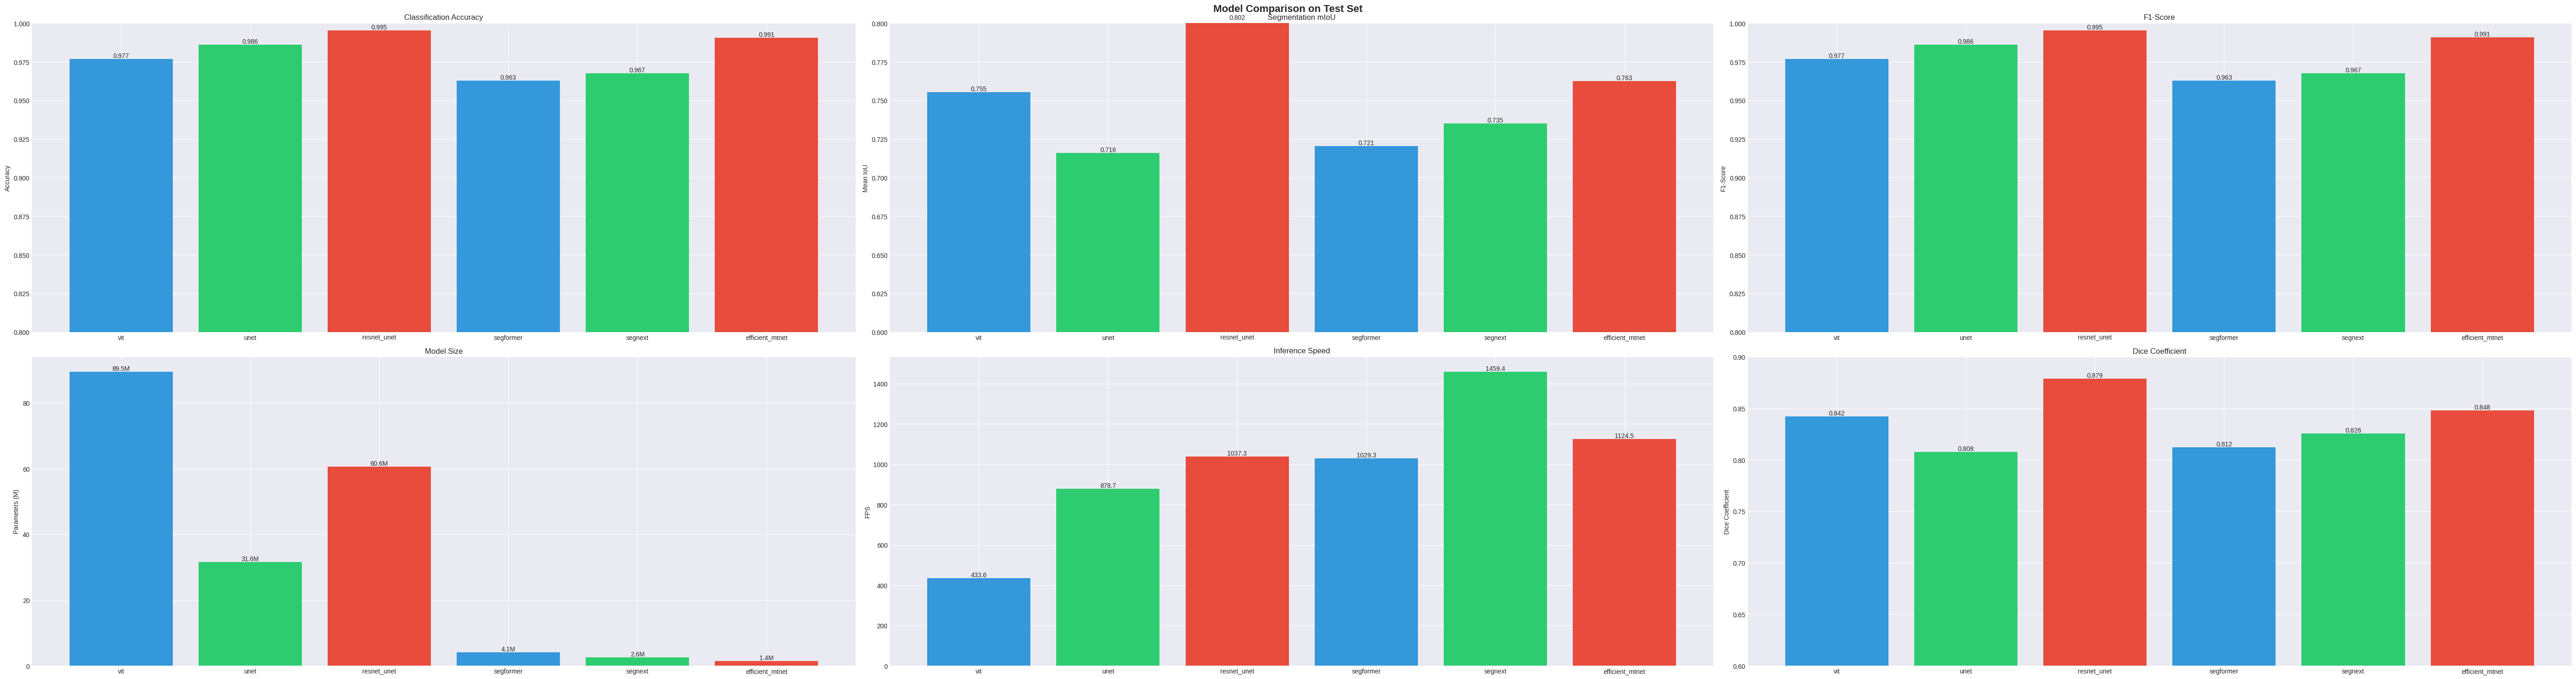

✓ Comparison plots saved to results/test_metrics_comparison.png


In [6]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(56, 15))
fig.suptitle('Model Comparison on Test Set', fontsize=16, fontweight='bold')

models = list(all_results.keys())
colors = ['#3498db', '#2ecc71', '#e74c3c']

# 1. Accuracy
accuracies = [all_results[m]['accuracy'] for m in models]
bars = axes[0, 0].bar(models, accuracies, color=colors)
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Classification Accuracy')
axes[0, 0].set_ylim([0.8, 1.0])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{accuracies[i]:.3f}', ha='center', va='bottom')

# 2. mIoU
mious = [all_results[m]['mean_iou'] for m in models]
bars = axes[0, 1].bar(models, mious, color=colors)
axes[0, 1].set_ylabel('Mean IoU')
axes[0, 1].set_title('Segmentation mIoU')
axes[0, 1].set_ylim([0.6, 0.8])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{mious[i]:.3f}', ha='center', va='bottom')

# 3. F1-Score
f1_scores = [all_results[m]['f1_score'] for m in models]
bars = axes[0, 2].bar(models, f1_scores, color=colors)
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].set_title('F1-Score')
axes[0, 2].set_ylim([0.8, 1.0])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{f1_scores[i]:.3f}', ha='center', va='bottom')

# 4. Parameters
params = [all_results[m]['parameters']/1e6 for m in models]
bars = axes[1, 0].bar(models, params, color=colors)
axes[1, 0].set_ylabel('Parameters (M)')
axes[1, 0].set_title('Model Size')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{params[i]:.1f}M', ha='center', va='bottom')

# 5. FPS
fps_values = [all_results[m]['fps'] for m in models]
bars = axes[1, 1].bar(models, fps_values, color=colors)
axes[1, 1].set_ylabel('FPS')
axes[1, 1].set_title('Inference Speed')
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{fps_values[i]:.1f}', ha='center', va='bottom')

# 6. Dice Coefficient
dice_scores = [all_results[m]['dice_coefficient'] for m in models]
bars = axes[1, 2].bar(models, dice_scores, color=colors)
axes[1, 2].set_ylabel('Dice Coefficient')
axes[1, 2].set_title('Dice Coefficient')
axes[1, 2].set_ylim([0.6, 0.9])
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[1, 2].text(bar.get_x() + bar.get_width()/2., height,
                   f'{dice_scores[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('results/test_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plots saved to results/test_metrics_comparison.png")

Loaded history for vit: 50 epochs
Loaded history for unet: 50 epochs
Loaded history for resnet_unet: 50 epochs
Loaded history for segformer: 50 epochs
Loaded history for segnext: 50 epochs
Loaded history for efficient_mtnet: 50 epochs


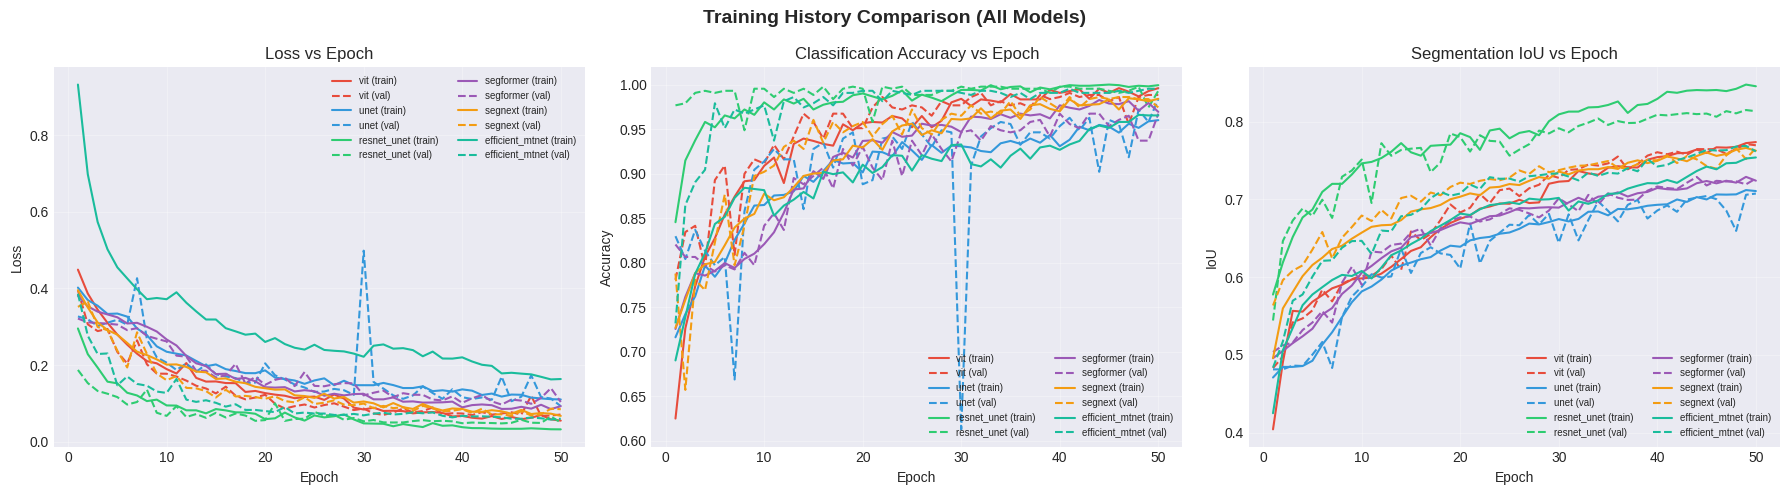

Training history plots saved to results/training_history_comparison.png


In [9]:
import json

# Load training history for all models
history_files = {
    'vit': 'results/vit_history.json',
    'unet': 'results/unet_history.json',
    'resnet_unet': 'results/resnet_unet_history.json',
    'segformer': 'results/lightweight_transformer_history.json',
    'segnext': 'results/segnext_history.json',
    'efficient_mtnet': 'results/efficient_mtnet_history.json'
}

all_history = {}
for model_name, path in history_files.items():
    if os.path.exists(path):
        with open(path, 'r') as f:
            all_history[model_name] = json.load(f)
        print(f"Loaded history for {model_name}: {len(all_history[model_name]['train_loss'])} epochs")
    else:
        print(f"History not found: {path}")

# Define colors for each model
model_colors = {
    'vit': '#e74c3c',
    'unet': '#3498db',
    'resnet_unet': '#2ecc71',
    'segformer': '#9b59b6',
    'segnext': '#f39c12',
    'efficient_mtnet': '#1abc9c'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History Comparison (All Models)', fontsize=14, fontweight='bold')

# Plot 1: Loss vs Epoch
ax1 = axes[0]
for model_name, history in all_history.items():
    epochs = range(1, len(history['train_loss']) + 1)
    color = model_colors.get(model_name, '#333333')
    ax1.plot(epochs, history['train_loss'], color=color, linestyle='-', linewidth=1.5, label=f'{model_name} (train)')
    ax1.plot(epochs, history['val_loss'], color=color, linestyle='--', linewidth=1.5, label=f'{model_name} (val)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Epoch')
ax1.legend(loc='upper right', fontsize=7, ncol=2)
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy vs Epoch
ax2 = axes[1]
for model_name, history in all_history.items():
    epochs = range(1, len(history['train_cls_acc']) + 1)
    color = model_colors.get(model_name, '#333333')
    ax2.plot(epochs, history['train_cls_acc'], color=color, linestyle='-', linewidth=1.5, label=f'{model_name} (train)')
    ax2.plot(epochs, history['val_cls_acc'], color=color, linestyle='--', linewidth=1.5, label=f'{model_name} (val)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Classification Accuracy vs Epoch')
ax2.legend(loc='lower right', fontsize=7, ncol=2)
ax2.grid(True, alpha=0.3)

# Plot 3: IoU vs Epoch
ax3 = axes[2]
for model_name, history in all_history.items():
    epochs = range(1, len(history['train_seg_iou']) + 1)
    color = model_colors.get(model_name, '#333333')
    ax3.plot(epochs, history['train_seg_iou'], color=color, linestyle='-', linewidth=1.5, label=f'{model_name} (train)')
    ax3.plot(epochs, history['val_seg_iou'], color=color, linestyle='--', linewidth=1.5, label=f'{model_name} (val)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_title('Segmentation IoU vs Epoch')
ax3.legend(loc='lower right', fontsize=7, ncol=2)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved to results/training_history_comparison.png")


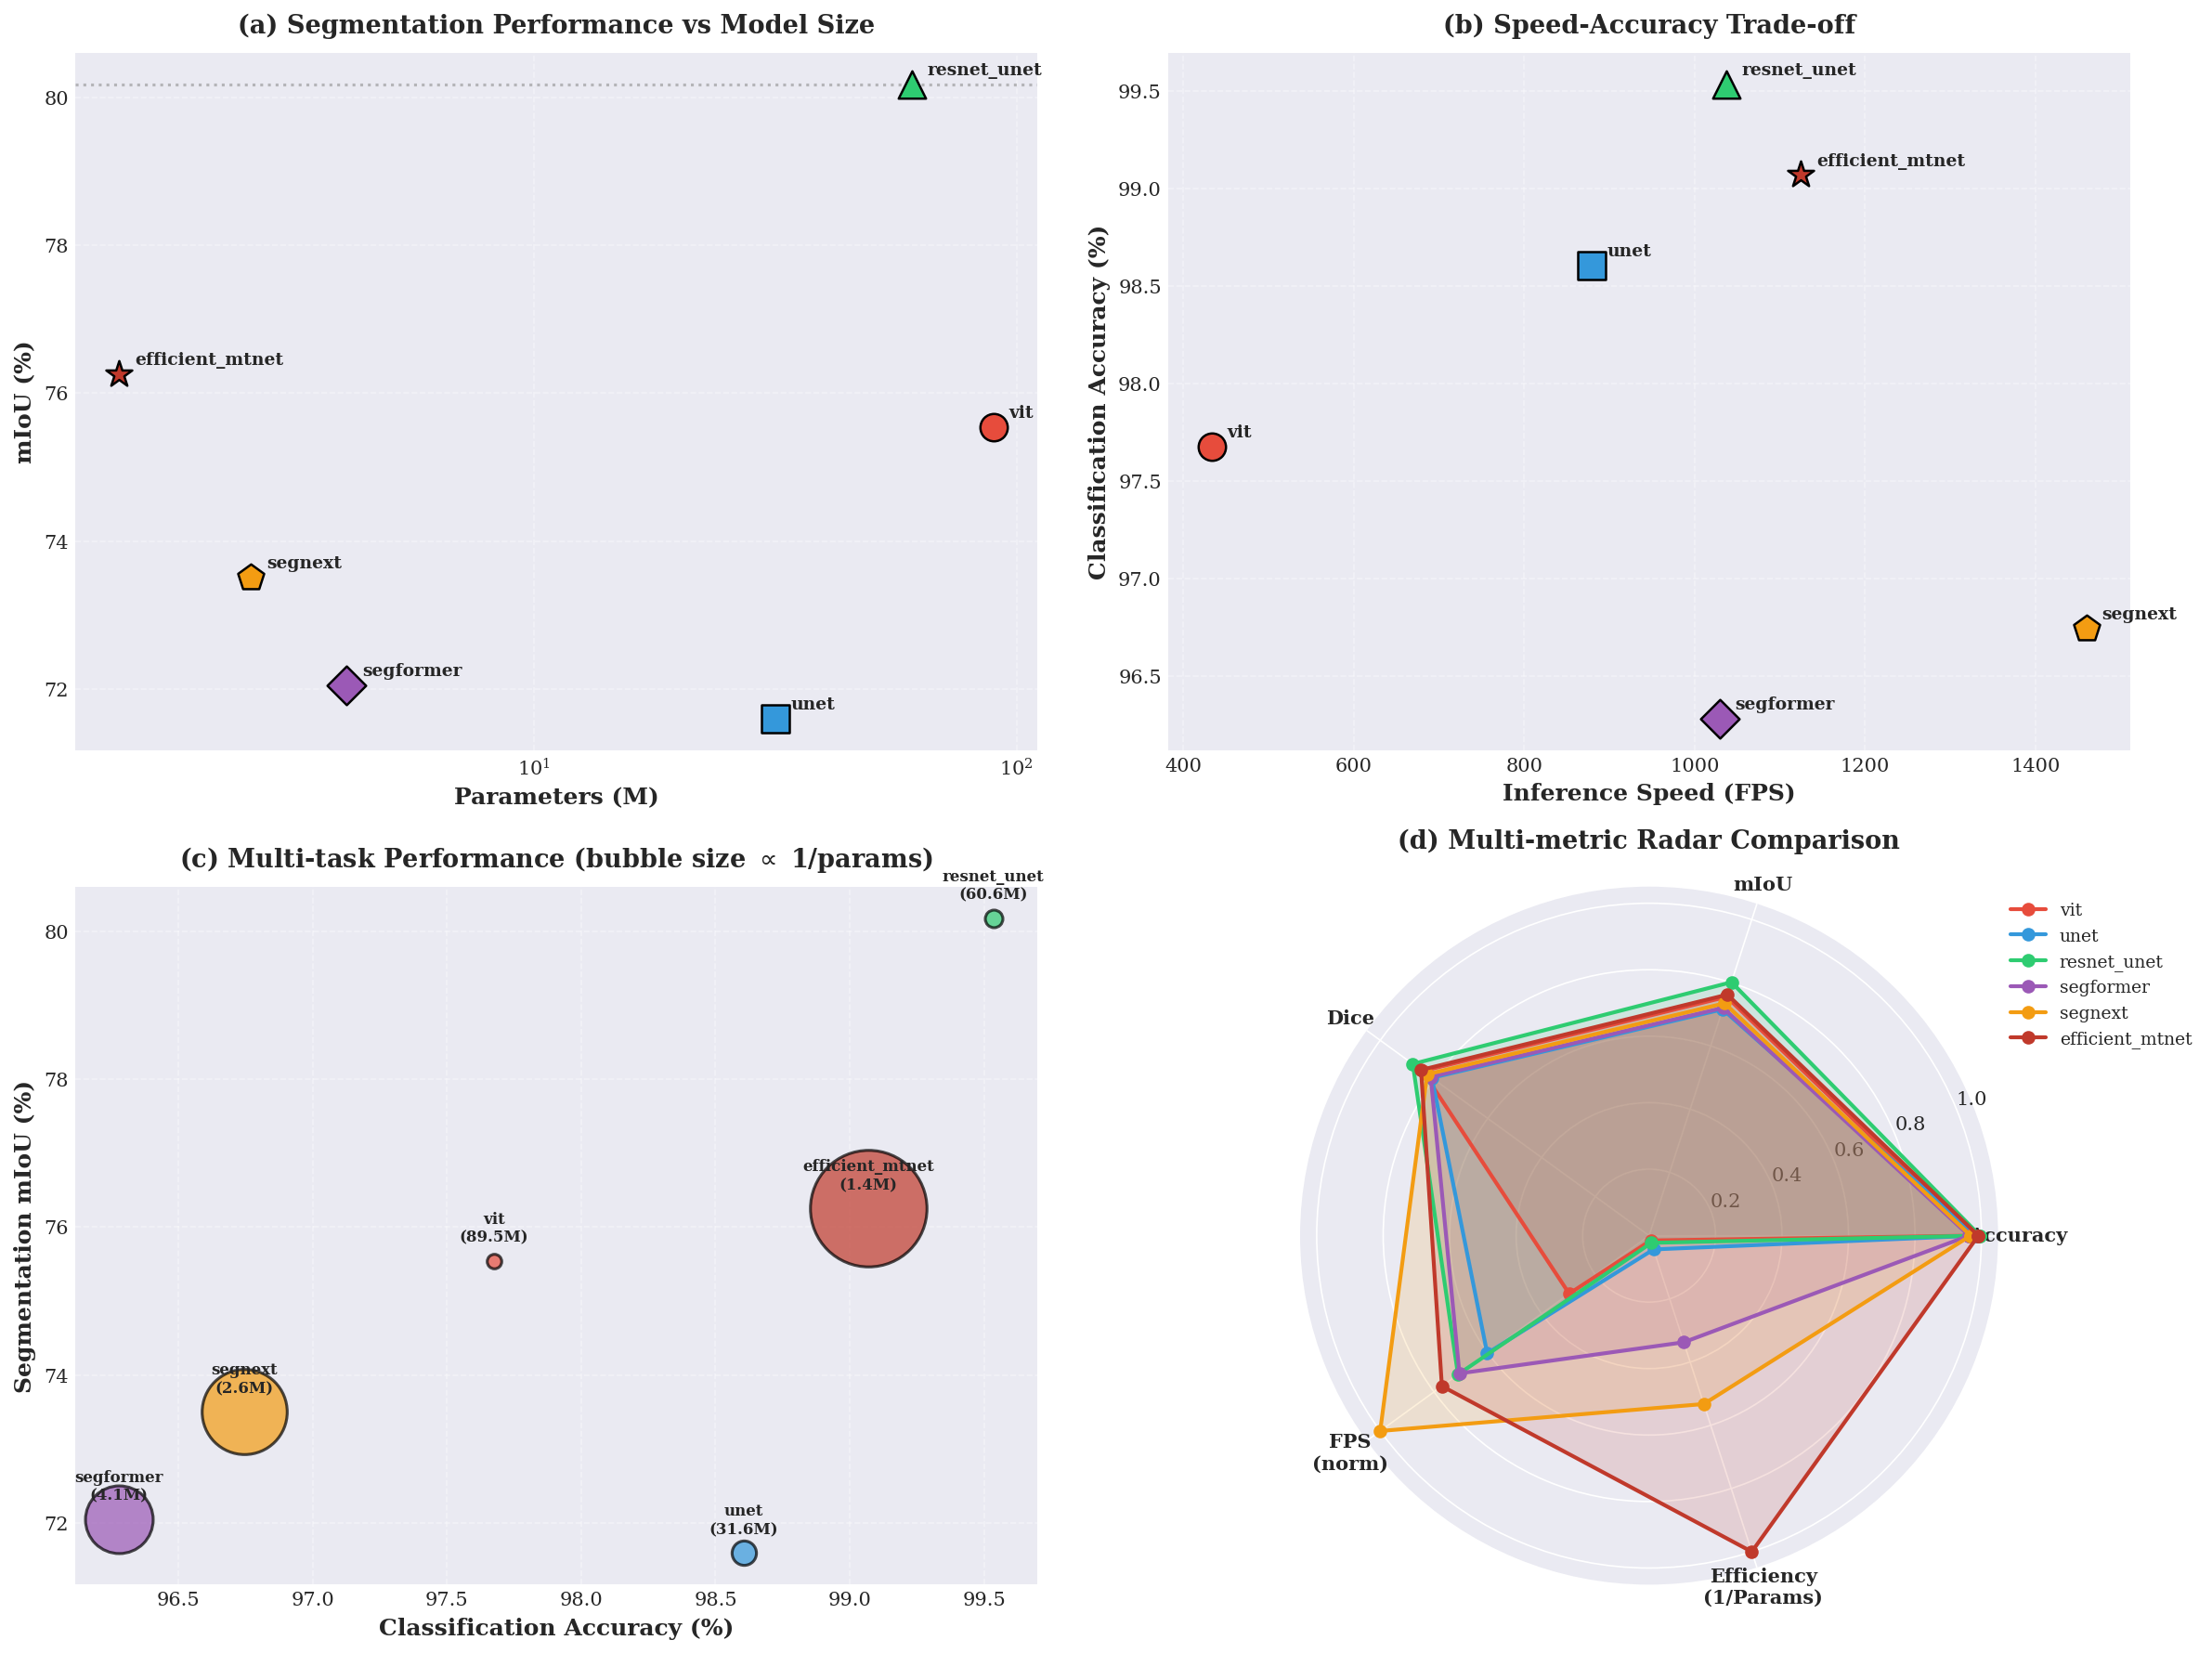

CVPR-style comparison plots saved to results/cvpr_style_comparison.png


In [10]:
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# CVPR-style publication plots
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 9,
    'figure.dpi': 150
})

model_colors = {
    'vit': '#e74c3c',
    'unet': '#3498db',
    'resnet_unet': '#2ecc71',
    'segformer': '#9b59b6',
    'segnext': '#f39c12',
    'efficient_mtnet': '#c0392b'
}

model_markers = {
    'vit': 'o',
    'unet': 's',
    'resnet_unet': '^',
    'segformer': 'D',
    'segnext': 'p',
    'efficient_mtnet': '*'
}

fig = plt.figure(figsize=(16, 12))

# Plot 1: mIoU vs Parameters (Efficiency Plot) - Top Left
ax1 = fig.add_subplot(2, 2, 1)
for model_name, results in all_results.items():
    params = results['parameters'] / 1e6
    miou = results['mean_iou'] * 100
    ax1.scatter(params, miou, c=model_colors[model_name], marker=model_markers[model_name],
                s=200, edgecolors='black', linewidths=1.2, label=model_name, zorder=3)
    ax1.annotate(model_name, (params, miou), textcoords="offset points",
                 xytext=(8, 5), fontsize=9, fontweight='bold')

ax1.set_xlabel('Parameters (M)', fontweight='bold')
ax1.set_ylabel('mIoU (%)', fontweight='bold')
ax1.set_title('(a) Segmentation Performance vs Model Size', fontweight='bold', pad=10)
ax1.grid(True, linestyle='--', alpha=0.4, zorder=0)
ax1.set_xscale('log')
ax1.axhline(y=max([r['mean_iou']*100 for r in all_results.values()]), color='gray', linestyle=':', alpha=0.5)

# Plot 2: Accuracy vs FPS (Speed-Accuracy Trade-off) - Top Right
ax2 = fig.add_subplot(2, 2, 2)
for model_name, results in all_results.items():
    fps = results['fps']
    acc = results['accuracy'] * 100
    ax2.scatter(fps, acc, c=model_colors[model_name], marker=model_markers[model_name],
                s=200, edgecolors='black', linewidths=1.2, label=model_name, zorder=3)
    ax2.annotate(model_name, (fps, acc), textcoords="offset points",
                 xytext=(8, 5), fontsize=9, fontweight='bold')

ax2.set_xlabel('Inference Speed (FPS)', fontweight='bold')
ax2.set_ylabel('Classification Accuracy (%)', fontweight='bold')
ax2.set_title('(b) Speed-Accuracy Trade-off', fontweight='bold', pad=10)
ax2.grid(True, linestyle='--', alpha=0.4, zorder=0)

# Plot 3: Bubble Chart - mIoU vs Accuracy with bubble size = 1/params (efficiency) - Bottom Left
ax3 = fig.add_subplot(2, 2, 3)
for model_name, results in all_results.items():
    acc = results['accuracy'] * 100
    miou = results['mean_iou'] * 100
    params = results['parameters'] / 1e6
    bubble_size = (100 / params) * 50
    ax3.scatter(acc, miou, c=model_colors[model_name], marker='o',
                s=bubble_size, alpha=0.7, edgecolors='black', linewidths=1.5, label=model_name, zorder=3)
    ax3.annotate(f'{model_name}\n({params:.1f}M)', (acc, miou), textcoords="offset points",
                 xytext=(0, 10), fontsize=8, ha='center', fontweight='bold')

ax3.set_xlabel('Classification Accuracy (%)', fontweight='bold')
ax3.set_ylabel('Segmentation mIoU (%)', fontweight='bold')
ax3.set_title('(c) Multi-task Performance (bubble size $\\propto$ 1/params)', fontweight='bold', pad=10)
ax3.grid(True, linestyle='--', alpha=0.4, zorder=0)

# Plot 4: Radar Chart - Bottom Right
ax4 = fig.add_subplot(2, 2, 4, projection='polar')

categories = ['Accuracy', 'mIoU', 'Dice', 'FPS\n(norm)', 'Efficiency\n(1/Params)']
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

max_fps = max([r['fps'] for r in all_results.values()])
max_efficiency = max([1/(r['parameters']/1e6) for r in all_results.values()])

for model_name, results in all_results.items():
    values = [
        results['accuracy'],
        results['mean_iou'],
        results['dice_coefficient'],
        results['fps'] / max_fps,
        (1/(results['parameters']/1e6)) / max_efficiency
    ]
    values += values[:1]
    ax4.plot(angles, values, 'o-', linewidth=2, color=model_colors[model_name], label=model_name, markersize=6)
    ax4.fill(angles, values, alpha=0.15, color=model_colors[model_name])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories, fontweight='bold')
ax4.set_ylim(0, 1.05)
ax4.set_title('(d) Multi-metric Radar Comparison', fontweight='bold', pad=20)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('results/cvpr_style_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("CVPR-style comparison plots saved to results/cvpr_style_comparison.png")


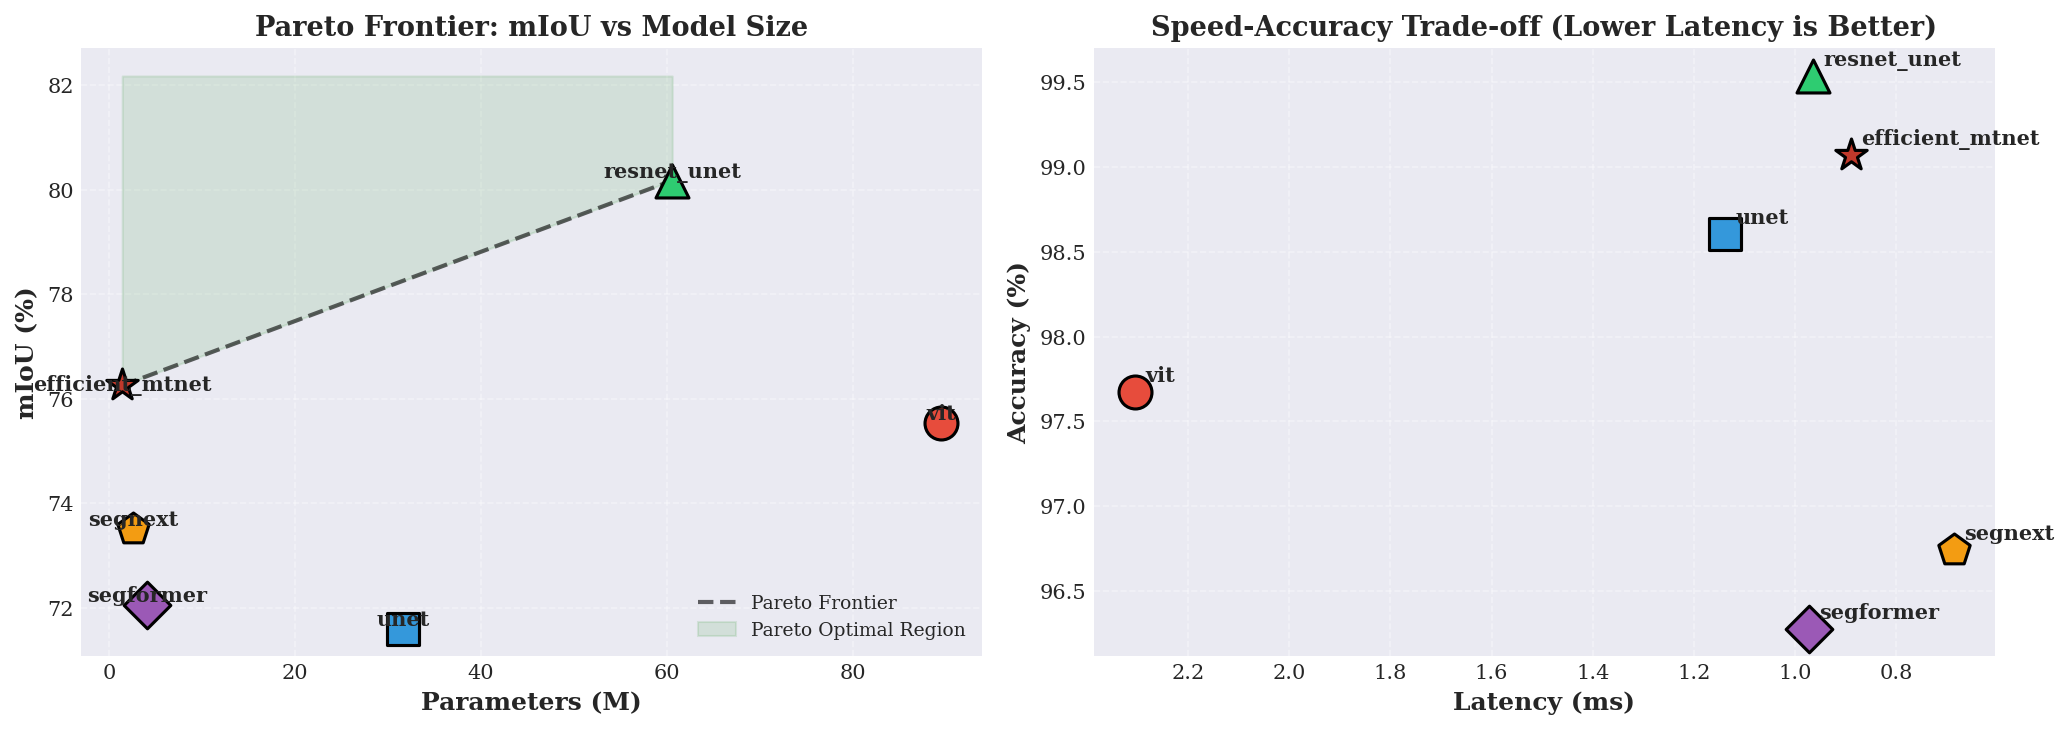

Pareto frontier plots saved to results/pareto_frontier.png


In [11]:
# Pareto Frontier Plot (common in efficiency papers)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Pareto - mIoU vs Parameters
ax1 = axes[0]
points = [(all_results[m]['parameters']/1e6, all_results[m]['mean_iou']*100, m) for m in all_results]
points_sorted = sorted(points, key=lambda x: x[0])

for params, miou, name in points:
    ax1.scatter(params, miou, c=model_colors[name], marker=model_markers[name],
                s=250, edgecolors='black', linewidths=1.5, zorder=3)
    offset_y = 1.5 if name != 'efficient_mtnet' else -2.5
    ax1.annotate(name, (params, miou), textcoords="offset points",
                 xytext=(0, offset_y), fontsize=10, ha='center', fontweight='bold')

# Draw Pareto frontier
pareto_points = []
max_miou = 0
for params, miou, name in sorted(points, key=lambda x: x[0]):
    if miou > max_miou:
        pareto_points.append((params, miou, name))
        max_miou = miou

if len(pareto_points) > 1:
    pareto_x = [p[0] for p in pareto_points]
    pareto_y = [p[1] for p in pareto_points]
    ax1.plot(pareto_x, pareto_y, 'k--', linewidth=2, alpha=0.6, label='Pareto Frontier')

ax1.fill_between([p[0] for p in pareto_points], [p[1] for p in pareto_points], 
                  max([p[1] for p in points])+2, alpha=0.1, color='green', label='Pareto Optimal Region')

ax1.set_xlabel('Parameters (M)', fontsize=12, fontweight='bold')
ax1.set_ylabel('mIoU (%)', fontsize=12, fontweight='bold')
ax1.set_title('Pareto Frontier: mIoU vs Model Size', fontsize=13, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(loc='lower right')

# Plot 2: Pareto - Accuracy vs Latency (1/FPS)
ax2 = axes[1]
for model_name, results in all_results.items():
    latency = 1000 / results['fps']  # ms
    acc = results['accuracy'] * 100
    ax2.scatter(latency, acc, c=model_colors[model_name], marker=model_markers[model_name],
                s=250, edgecolors='black', linewidths=1.5, zorder=3)
    ax2.annotate(model_name, (latency, acc), textcoords="offset points",
                 xytext=(5, 5), fontsize=10, fontweight='bold')

ax2.set_xlabel('Latency (ms)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Speed-Accuracy Trade-off (Lower Latency is Better)', fontsize=13, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.invert_xaxis()

plt.tight_layout()
plt.savefig('results/pareto_frontier.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Pareto frontier plots saved to results/pareto_frontier.png")


## 7. Confusion Matrices

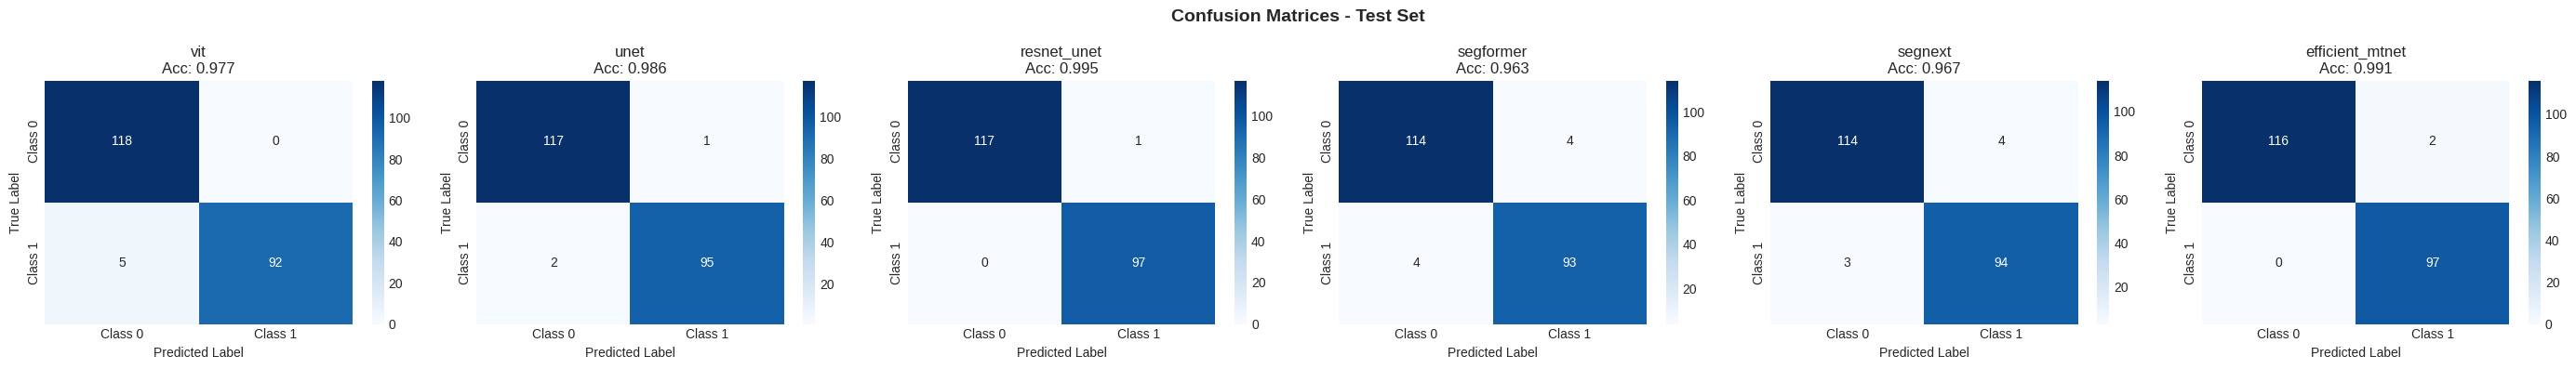

✓ Confusion matrices saved to results/confusion_matrices.png


In [7]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 6, figsize=(28, 4))
fig.suptitle('Confusion Matrices - Test Set', fontsize=14, fontweight='bold')

for idx, (model_name, results) in enumerate(all_results.items()):
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
               xticklabels=['Class 0', 'Class 1'],
               yticklabels=['Class 0', 'Class 1'])
    axes[idx].set_title(f'{model_name}\nAcc: {results["accuracy"]:.3f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrices saved to results/confusion_matrices.png")

## 8. Visualize Sample Predictions

In [ ]:
def denormalize_image(image_tensor):
    """Denormalize image for visualization"""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    image = std * image + mean
    return np.clip(image, 0, 1)

def visualize_model_predictions(model_name, checkpoint_path, num_to_display=5, save_all=True):
    """Visualize and save predictions for a specific model"""
    if save_all:
        print(f"\nProcessing ALL test images for {model_name} (displaying first {num_to_display})...")
    else:
        print(f"\nProcessing {num_to_display} samples for {model_name}...")
    
    output_dir = f'results/{model_name}_predictions'
    os.makedirs(output_dir, exist_ok=True)
    
    model = get_model(
        model_name=model_name,
        n_classes_seg=config.SEGMENTATION_CLASSES,
        n_classes_cls=config.NUM_CLASSES - 1,
        img_size=config.IMAGE_SIZE
    ).to(config.DEVICE)
    
    checkpoint = torch.load(checkpoint_path, map_location=config.DEVICE, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    sample_count = 0
    for batch in test_loader:
        images = batch['image'].to(config.DEVICE)
        seg_masks = batch['segmentation_mask']
        cls_labels = batch['classification_label']
        
        with torch.no_grad():
            cls_output, seg_output = model(images)
            cls_preds = torch.argmax(cls_output, dim=1).cpu()
            seg_preds = torch.argmax(seg_output, dim=1).cpu()
        
        for i in range(images.size(0)):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            
            img = denormalize_image(images[i])
            
            axes[0].imshow(img)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(img)
            axes[1].imshow(seg_masks[i].numpy(), alpha=0.5, cmap='Reds')
            axes[1].set_title(f'Ground Truth\nClass: {cls_labels[i].item()}')
            axes[1].axis('off')
            
            axes[2].imshow(img)
            axes[2].imshow(seg_preds[i].numpy(), alpha=0.5, cmap='Reds')
            correct = '✓' if cls_preds[i].item() == cls_labels[i].item() else '✗'
            axes[2].set_title(f'Prediction {correct}\nClass: {cls_preds[i].item()}')
            axes[2].axis('off')
            
            gt = seg_masks[i].numpy()
            pred = seg_preds[i].numpy()
            overlay = np.zeros((*gt.shape, 3))
            overlay[np.logical_and(gt == 1, pred == 1)] = [0, 1, 0]
            overlay[np.logical_and(gt == 0, pred == 1)] = [1, 0, 0]
            overlay[np.logical_and(gt == 1, pred == 0)] = [0, 0, 1]
            axes[3].imshow(img)
            axes[3].imshow(overlay, alpha=0.6)
            axes[3].set_title('Overlay\n(Green=TP, Red=FP, Blue=FN)')
            axes[3].axis('off')
            
            plt.suptitle(f'Sample {sample_count + 1} - {model_name}', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'{output_dir}/sample_{sample_count+1}.png', dpi=150, bbox_inches='tight')
            
            if sample_count < num_to_display:
                plt.show()
            else:
                plt.close(fig)
            
            sample_count += 1
        
        if not save_all and sample_count >= num_to_display:
            break
    
    print(f"✓ {sample_count} predictions saved to {output_dir}/")
    return sample_count

for model_name, checkpoint_path in MODELS_TO_TEST.items():
    if os.path.exists(checkpoint_path):
        visualize_model_predictions(model_name, checkpoint_path, NUM_SAMPLES_TO_DISPLAY, SAVE_ALL_TEST_IMAGES)
    else:
        print(f"\n⚠ Checkpoint not found: {checkpoint_path}")

print(f"\n✓ All visualizations completed for {len(all_results)} models")